In [2]:
import zipfile
import os
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
from transformers import CLIPProcessor, CLIPModel
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

In [3]:
!cat /proc/cpuinfo | grep "model name" | uniq #CPU

model name	: Intel(R) Xeon(R) CPU @ 2.20GHz


In [4]:
!nvidia-smi #GPU

Mon Dec  9 16:18:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              50W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [5]:
import platform

# 운영체제 정보 확인
os_info = platform.system()
print(f"Operating System: {os_info}")

Operating System: Linux


In [6]:
#install SoccerNet library
!pip install SoccerNet --upgrade

import SoccerNet
from SoccerNet.Downloader import SoccerNetDownloader

#create downloader
mySoccerNetDownloader = SoccerNetDownloader(LocalDirectory="/dataset/SoccerNet")

In [7]:
#set dataset directory
local_directory = "/content/SoccerNet"  # Colab의 경우 기본 경로

#create SoccerNetDownloader instance
my_downloader = SoccerNetDownloader(LocalDirectory=local_directory)

#download 10 games as test
download_index = 0

for download_index in range(0, 40):
  mySoccerNetDownloader.downloadGameIndex(download_index, files=["Labels-v3.json", "Frames-v3.zip"])

/dataset/SoccerNet/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/Labels-v3.json already exists
/dataset/SoccerNet/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/Frames-v3.zip already exists
/dataset/SoccerNet/england_epl/2014-2015/2015-02-21 - 18-00 Crystal Palace 1 - 2 Arsenal/Labels-v3.json already exists
/dataset/SoccerNet/england_epl/2014-2015/2015-02-21 - 18-00 Crystal Palace 1 - 2 Arsenal/Frames-v3.zip already exists
/dataset/SoccerNet/england_epl/2014-2015/2015-02-21 - 18-00 Swansea 2 - 1 Manchester United/Labels-v3.json already exists
/dataset/SoccerNet/england_epl/2014-2015/2015-02-21 - 18-00 Swansea 2 - 1 Manchester United/Frames-v3.zip already exists
/dataset/SoccerNet/england_epl/2014-2015/2015-02-22 - 19-15 Southampton 0 - 2 Liverpool/Labels-v3.json already exists
/dataset/SoccerNet/england_epl/2014-2015/2015-02-22 - 19-15 Southampton 0 - 2 Liverpool/Frames-v3.zip already exists
/dataset/SoccerNet/england_epl/2015-2016/2015-08-08 - 19-30 Ch

In [8]:
data_paths = [
    "/dataset/SoccerNet/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley",
    "/dataset/SoccerNet/england_epl/2014-2015/2015-02-21 - 18-00 Crystal Palace 1 - 2 Arsenal",
    "/dataset/SoccerNet/england_epl/2014-2015/2015-02-21 - 18-00 Swansea 2 - 1 Manchester United",
    "/dataset/SoccerNet/england_epl/2014-2015/2015-02-22 - 19-15 Southampton 0 - 2 Liverpool",
    "/dataset/SoccerNet/england_epl/2015-2016/2015-08-08 - 19-30 Chelsea 2 - 2 Swansea",
    "/dataset/SoccerNet/england_epl/2015-2016/2015-08-29 - 17-00 Chelsea 1 - 2 Crystal Palace",
    "/dataset/SoccerNet/england_epl/2015-2016/2015-08-29 - 17-00 Manchester City 2 - 0 Watford",
    "/dataset/SoccerNet/england_epl/2015-2016/2015-09-12 - 14-45 Everton 3 - 1 Chelsea",
    "/dataset/SoccerNet/england_epl/2015-2016/2015-09-12 - 17-00 Crystal Palace 0 - 1 Manchester City",
    "/dataset/SoccerNet/england_epl/2015-2016/2015-09-19 - 19-30 Manchester City 1 - 2 West Ham",
    "/dataset/SoccerNet/england_epl/2015-2016/2015-09-26 - 17-00 Liverpool 3 - 2 Aston Villa",
    "/dataset/SoccerNet/england_epl/2015-2016/2015-10-17 - 17-00 Chelsea 2 - 0 Aston Villa",
    "/dataset/SoccerNet/england_epl/2015-2016/2015-10-31 - 15-45 Chelsea 1 - 3 Liverpool",
    "/dataset/SoccerNet/england_epl/2015-2016/2015-11-07 - 18-00 Manchester United 2 - 0 West Brom",
    "/dataset/SoccerNet/england_epl/2015-2016/2015-11-21 - 20-30 Manchester City 1 - 4 Liverpool",
    "/dataset/SoccerNet/england_epl/2015-2016/2015-11-29 - 15-00 Tottenham 0 - 0 Chelsea",
    "/dataset/SoccerNet/england_epl/2015-2016/2015-12-05 - 20-30 Chelsea 0 - 1 Bournemouth",
    "/dataset/SoccerNet/england_epl/2015-2016/2015-12-19 - 18-00 Chelsea 3 - 1 Sunderland",
    "/dataset/SoccerNet/england_epl/2015-2016/2015-12-26 - 18-00 Manchester City 4 - 1 Sunderland",
    "/dataset/SoccerNet/england_epl/2015-2016/2016-01-03 - 16-30 Crystal Palace 0 - 3 Chelsea",
    "/dataset/SoccerNet/england_epl/2015-2016/2016-01-13 - 22-45 Chelsea 2 - 2 West Brom",
    "/dataset/SoccerNet/england_epl/2015-2016/2016-02-07 - 19-00 Chelsea 1 - 1 Manchester United",
    "/dataset/SoccerNet/england_epl/2015-2016/2016-02-14 - 19-15 Manchester City 1 - 2 Tottenham",
    "/dataset/SoccerNet/england_epl/2015-2016/2016-03-02 - 23-00 Liverpool 3 - 0 Manchester City",
    "/dataset/SoccerNet/england_epl/2015-2016/2016-03-05 - 18-00 Chelsea 1 - 1 Stoke City",
    "/dataset/SoccerNet/england_epl/2015-2016/2016-03-19 - 18-00 Chelsea 2 - 2 West Ham",
    "/dataset/SoccerNet/england_epl/2015-2016/2016-04-09 - 17-00 Swansea 1 - 0 Chelsea",
    "/dataset/SoccerNet/england_epl/2015-2016/2016-04-09 - 19-30 Manchester City 2 - 1 West Brom",
    "/dataset/SoccerNet/england_epl/2015-2016/2016-05-07 - 17-00 Sunderland 3 - 2 Chelsea",
    "/dataset/SoccerNet/england_epl/2016-2017/2016-08-14 - 18-00 Arsenal 3 - 4 Liverpool",
    "/dataset/SoccerNet/england_epl/2016-2017/2016-08-20 - 17-00 Burnley 2 - 0 Liverpool",
    "/dataset/SoccerNet/england_epl/2016-2017/2016-08-20 - 19-30 Leicester 0 - 0 Arsenal",
    "/dataset/SoccerNet/england_epl/2016-2017/2016-09-10 - 17-00 Arsenal 2 - 1 Southampton",
    "/dataset/SoccerNet/england_epl/2016-2017/2016-09-16 - 22-00 Chelsea 1 - 2 Liverpool",
    "/dataset/SoccerNet/england_epl/2016-2017/2016-09-17 - 17-00 Hull City 1 - 4 Arsenal",
    "/dataset/SoccerNet/england_epl/2016-2017/2016-09-24 - 19-30 Arsenal 3 - 0 Chelsea",
    "/dataset/SoccerNet/england_epl/2016-2017/2016-10-17 - 22-00 Liverpool 0 - 0 Manchester United",
    "/dataset/SoccerNet/england_epl/2016-2017/2016-10-22 - 19-30 Liverpool 2 - 1 West Brom",
    "/dataset/SoccerNet/england_epl/2016-2017/2016-10-29 - 14-30 Sunderland 1 - 4 Arsenal",
    "/dataset/SoccerNet/england_epl/2016-2017/2016-10-29 - 17-00 Tottenham 1 - 1 Leicester"
]

In [9]:
import json

folder1_path = "/dataset/SoccerNet/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/Labels-v3.json"
folder2_path = "/dataset/SoccerNet/england_epl/2014-2015/2015-02-21 - 18-00 Crystal Palace 1 - 2 Arsenal/Labels-v3.json"

#england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley
#open "Labels-v3.json" -1
with open(folder1_path, "r") as file1:
    data1 = json.load(file1)

#england_epl/2014-2015/2015-02-21 - 18-00 Crystal Palace 1 - 2 Arsenal
#open "Labels-v3.json" -2
with open(folder2_path, "r") as file2:
    data2 = json.load(file2)

#extract label from "action" section
actions1 = data1["actions"]
actions2 = data2["actions"]

labels1 = {}
labels2 = {}

for image, metadata in actions1.items():
    labels1[image] = metadata["imageMetadata"]["label"]

for image, metadata in actions2.items():
    labels2[image] = metadata["imageMetadata"]["label"]

#print and check the pairing of images and labels
print("england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley")
for image, label in labels1.items():
    print(f"Image: {image}, Label: {label}")

print("\n\nengland_epl/2014-2015/2015-02-21 - 18-00 Crystal Palace 1 - 2 Arsenal")
for image, label in labels2.items():
    print(f"Image: {image}, Label: {label}")

england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley
Image: 0.png, Label: Ball out of play
Image: 1.png, Label: Goal
Image: 2.png, Label: Clearance
Image: 3.png, Label: Shots off target
Image: 4.png, Label: Ball out of play
Image: 5.png, Label: Foul
Image: 6.png, Label: Corner
Image: 7.png, Label: Ball out of play
Image: 8.png, Label: Foul
Image: 9.png, Label: Foul
Image: 10.png, Label: Shots on target
Image: 11.png, Label: Ball out of play
Image: 12.png, Label: Ball out of play
Image: 13.png, Label: Shots on target
Image: 14.png, Label: Ball out of play
Image: 15.png, Label: Clearance
Image: 16.png, Label: Throw-in
Image: 17.png, Label: Shots off target
Image: 18.png, Label: Shots off target
Image: 19.png, Label: Ball out of play
Image: 20.png, Label: Goal
Image: 21.png, Label: Throw-in
Image: 22.png, Label: Shots off target


england_epl/2014-2015/2015-02-21 - 18-00 Crystal Palace 1 - 2 Arsenal
Image: 0.png, Label: Offside
Image: 1.png, Label: Foul
Image: 2.png, Label: Foul

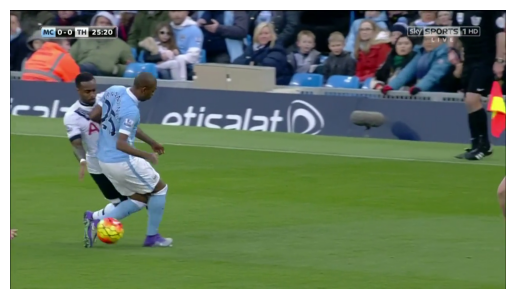

In [10]:
zip_path = "/dataset/SoccerNet/england_epl/2015-2016/2016-02-14 - 19-15 Manchester City 1 - 2 Tottenham/Frames-v3.zip"

#open zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:

    image_names = [name for name in zip_ref.namelist() if name.endswith(".png")]

    with zip_ref.open(image_names[0]) as image_file:
        image = Image.open(image_file)
        #visualization sample image
        plt.imshow(image)
        plt.axis("off") #set axes invisible.
        plt.show()

Loaded 69 images and 69 labels.


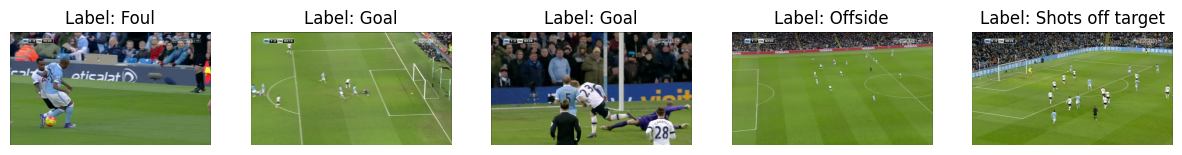

In [11]:
#matching png file from zip folder and label from json file - example
zip_path = "/dataset/SoccerNet/england_epl/2015-2016/2016-02-14 - 19-15 Manchester City 1 - 2 Tottenham/Frames-v3.zip"
json_path = "/dataset/SoccerNet/england_epl/2015-2016/2016-02-14 - 19-15 Manchester City 1 - 2 Tottenham/Labels-v3.json"

#image transformation pipeline (convert to PyTorch tensor)
transform = transforms.Compose([
    #transforms.Resize((224, 224)),  #resize
    transforms.ToTensor(),          #convert to tensor
])

image_tensors = []
labels = []

with open(json_path, "r") as f:
    label_data = json.load(f)

#open zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:

    image_names = [name for name in zip_ref.namelist() if name.endswith(".png")]

    for image_name in image_names:
        #open png file
        with zip_ref.open(image_name) as image_file:
            image = Image.open(image_file).convert("RGB")  #convert to RGB
            #convert to image tensor
            image_tensor = transform(image)
            image_tensors.append(image_tensor)

        #find labels corresponding to image file and modify image name included '_' (underbar) to use as index
        if '_' in image_name:
          base_name = image_name.split("_")[0] + ".png"
        else:
          base_name = image_name
        label = label_data["actions"].get(base_name, {}).get("imageMetadata", {}).get("label", "Unknown")
        labels.append(label)

#check the number of images and labels
print(f"Loaded {len(image_tensors)} images and {len(labels)} labels.")

num_visualize = 5
fig, axes = plt.subplots(1, num_visualize, figsize=(15, 5))

for i in range(num_visualize):
    image = image_tensors[i].permute(1, 2, 0).numpy()
    label = labels[i]

    axes[i].imshow(image)
    axes[i].axis("off")
    axes[i].set_title(f"Label: {label}")

plt.show()

## Data Augmentation

- resize = transforms.Resize((224, 224))
- flip = transforms.RandomHorizontalFlip(p=1)
- rotate = transforms.RandomRotation(15)


In [12]:
#image transformation "basic" pipeline (convert to PyTorch tensor)
transform_basic = transforms.Compose([
    transforms.Resize((224, 224)),  #resize
    transforms.ToTensor(),          #convert to tensor
])

In [13]:
#image transformation "advanced" pipeline (convert to PyTorch tensor)
#data augmentation
transform_advanced = transforms.Compose([
    transforms.Resize((224, 224)),      #resize
    transforms.RandomHorizontalFlip(),  #horizontal flip
    transforms.RandomVerticalFlip(),    #vertical flip
    transforms.RandomRotation(15),      #radomly rotate
    transforms.ToTensor(),              #conver to Tensor
])

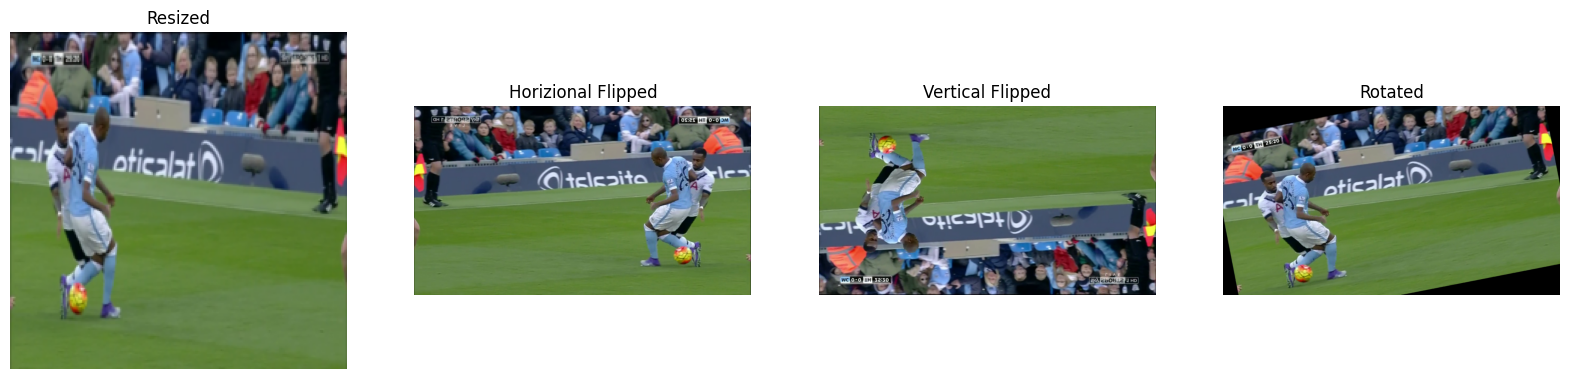

In [14]:
#test image path
image_path = '/dataset/SoccerNet/england_epl/2015-2016/2016-02-14 - 19-15 Manchester City 1 - 2 Tottenham/Frames-v3.zip'  # 이미지 경로

with zipfile.ZipFile(zip_path, 'r') as zip_ref:

    image_names = [name for name in zip_ref.namelist() if name.endswith(".png")]

    for image_name in image_names:
        #open png file
        with zip_ref.open(image_name) as image_file:
            image = Image.open(image_file).convert("RGB")  #convert to RGB
        break #only one needed test image

transform_resize = transforms.Resize((224, 224))
transform_hFlip = transforms.RandomHorizontalFlip(p=1)
transform_vFlip = transforms.RandomVerticalFlip(p=1)
transform_rotate = transforms.RandomRotation(15)

image_resized = transform_resize(image)
image_hFlipped = transform_hFlip(image)
image_vFlipped = transform_vFlip(image)
image_rotated = transform_rotate(image)

#visualization
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].imshow(image_resized)
axs[0].set_title("Resized")
axs[0].axis('off')

axs[1].imshow(image_hFlipped)
axs[1].set_title("Horizional Flipped")
axs[1].axis('off')

axs[2].imshow(image_vFlipped)
axs[2].set_title("Vertical Flipped")
axs[2].axis('off')

axs[3].imshow(image_rotated)
axs[3].set_title("Rotated")
axs[3].axis('off')


plt.show()



---



## Split Dataset
- training: 70%
- test: 20%
- validation: 10%

In [15]:
#split dataset as train, test, valid 3 categories
train_paths, temp_paths = train_test_split(data_paths, test_size=0.3, random_state=7)
test_paths, val_paths = train_test_split(temp_paths, test_size=0.33, random_state=32)

In [16]:
class SoccerNetDataset(Dataset):
    def __init__(self, data_paths, transform):
        self.data_paths = data_paths
        self.transform = transform
        self.image_tensors = []
        self.labels = []
        self.load_data()

    def load_data(self):
        for path in self.data_paths:
            zip_path = os.path.join(path, "Frames-v3.zip")      #zip -> png image
            json_path = os.path.join(path, "Labels-v3.json")    #json -> action label

            print(f"Loading JSON from: {json_path}")
            print(f"Loading ZIP from: {zip_path}")

            #load label data
            with open(json_path, "r") as f:
                label_data = json.load(f)

            #open zip file
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                image_names = [name for name in zip_ref.namelist() if name.endswith(".png")]

                for image_name in image_names:
                    #open and process image
                    with zip_ref.open(image_name) as image_file:
                        image = Image.open(image_file).convert("RGB")
                        image_tensor = self.transform(image)
                        self.image_tensors.append(image_tensor)

                    #extract label
                    base_name = image_name.split("_")[0] + ".png" if "_" in image_name else image_name
                    label = label_data["actions"].get(base_name, {}).get("imageMetadata", {}).get("label", "Unknown")
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_tensors)

    def __getitem__(self, idx):
        return {
            "image": self.image_tensors[idx],
            "label": self.labels[idx],
        }

In [17]:
#create data set
train_dataset_basic = SoccerNetDataset(train_paths, transform_basic)
test_dataset_basic = SoccerNetDataset(test_paths, transform_basic)
val_dataset_basic = SoccerNetDataset(val_paths, transform_basic)

Loading JSON from: /dataset/SoccerNet/england_epl/2015-2016/2015-11-07 - 18-00 Manchester United 2 - 0 West Brom/Labels-v3.json
Loading ZIP from: /dataset/SoccerNet/england_epl/2015-2016/2015-11-07 - 18-00 Manchester United 2 - 0 West Brom/Frames-v3.zip
Loading JSON from: /dataset/SoccerNet/england_epl/2015-2016/2016-04-09 - 19-30 Manchester City 2 - 1 West Brom/Labels-v3.json
Loading ZIP from: /dataset/SoccerNet/england_epl/2015-2016/2016-04-09 - 19-30 Manchester City 2 - 1 West Brom/Frames-v3.zip
Loading JSON from: /dataset/SoccerNet/england_epl/2015-2016/2015-08-29 - 17-00 Chelsea 1 - 2 Crystal Palace/Labels-v3.json
Loading ZIP from: /dataset/SoccerNet/england_epl/2015-2016/2015-08-29 - 17-00 Chelsea 1 - 2 Crystal Palace/Frames-v3.zip
Loading JSON from: /dataset/SoccerNet/england_epl/2015-2016/2015-11-29 - 15-00 Tottenham 0 - 0 Chelsea/Labels-v3.json
Loading ZIP from: /dataset/SoccerNet/england_epl/2015-2016/2015-11-29 - 15-00 Tottenham 0 - 0 Chelsea/Frames-v3.zip
Loading JSON from:

In [18]:
print("BASIC DATASET")
print(f"Train dataset size: {len(train_dataset_basic)}")
print(f"Test dataset size: {len(test_dataset_basic)}")
print(f"Validation dataset size: {len(val_dataset_basic)}")

BASIC DATASET
Train dataset size: 2045
Test dataset size: 684
Validation dataset size: 269


In [19]:
class SoccerNetDataset_advanced(Dataset):
    def __init__(self, data_paths, transform):
        self.data_paths = data_paths
        self.transform = transform
        self.image_tensors = []
        self.labels = []
        self.load_data()

    def load_data(self):
        for path in self.data_paths:
            zip_path = os.path.join(path, "Frames-v3.zip")      #zip -> png image
            json_path = os.path.join(path, "Labels-v3.json")    #json -> action label

            print(f"Loading JSON from: {json_path}")
            print(f"Loading ZIP from: {zip_path}")

            #load label data
            with open(json_path, "r") as f:
                label_data = json.load(f)

            #open zip file
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                image_names = [name for name in zip_ref.namelist() if name.endswith(".png")]

                for image_name in image_names:
                    #open and process image
                    with zip_ref.open(image_name) as image_file:
                        image = Image.open(image_file).convert("RGB")

                        original_image_tensor = self.transform(image)
                        self.image_tensors.append(original_image_tensor)

                        transform_resize = transforms.Resize((224, 224))
                        transform_hFlip = transforms.RandomHorizontalFlip(p=1)
                        transform_vFlip = transforms.RandomVerticalFlip(p=1)
                        transform_rotate = transforms.RandomRotation(15)

                        image_resized = transform_resize(image)
                        image_hFlipped = transform_hFlip(image)
                        image_vFlipped = transform_vFlip(image)
                        image_rotated = transform_rotate(image)

                        #augmented_images = [self.apply_augmentation(image, transform) for transform in self.transform.transforms]
                        self.image_tensors.append(transforms.ToTensor()(image_resized))
                        self.image_tensors.append(transforms.ToTensor()(image_hFlipped))
                        #self.image_tensors.append(transforms.ToTensor()(image_vFlipped))
                        #self.image_tensors.append(transforms.ToTensor()(image_rotated))

                    #extract label
                    base_name = image_name.split("_")[0] + ".png" if "_" in image_name else image_name
                    label = label_data["actions"].get(base_name, {}).get("imageMetadata", {}).get("label", "Unknown")
                    self.labels.append(label)
                    for i in range(0, 4): self.labels.append(label)

    def apply_augmentation(self, image, transform):
        return transform(image)

    def __len__(self):
        return len(self.image_tensors)

    def __getitem__(self, idx):
        return {
            "image": self.image_tensors[idx],
            "label": self.labels[idx],
        }

In [20]:
#create data set using advanced transform
train_dataset_advanced = SoccerNetDataset_advanced(train_paths, transform_advanced)
test_dataset_advanced = SoccerNetDataset_advanced(test_paths, transform_advanced)
val_dataset_advanced = SoccerNetDataset_advanced(val_paths, transform_advanced)

Loading JSON from: /dataset/SoccerNet/england_epl/2015-2016/2015-11-07 - 18-00 Manchester United 2 - 0 West Brom/Labels-v3.json
Loading ZIP from: /dataset/SoccerNet/england_epl/2015-2016/2015-11-07 - 18-00 Manchester United 2 - 0 West Brom/Frames-v3.zip
Loading JSON from: /dataset/SoccerNet/england_epl/2015-2016/2016-04-09 - 19-30 Manchester City 2 - 1 West Brom/Labels-v3.json
Loading ZIP from: /dataset/SoccerNet/england_epl/2015-2016/2016-04-09 - 19-30 Manchester City 2 - 1 West Brom/Frames-v3.zip
Loading JSON from: /dataset/SoccerNet/england_epl/2015-2016/2015-08-29 - 17-00 Chelsea 1 - 2 Crystal Palace/Labels-v3.json
Loading ZIP from: /dataset/SoccerNet/england_epl/2015-2016/2015-08-29 - 17-00 Chelsea 1 - 2 Crystal Palace/Frames-v3.zip
Loading JSON from: /dataset/SoccerNet/england_epl/2015-2016/2015-11-29 - 15-00 Tottenham 0 - 0 Chelsea/Labels-v3.json
Loading ZIP from: /dataset/SoccerNet/england_epl/2015-2016/2015-11-29 - 15-00 Tottenham 0 - 0 Chelsea/Frames-v3.zip
Loading JSON from:

In [21]:
print("ADVANCED DATASET")
print(f"Train dataset size: {len(train_dataset_advanced)}")
print(f"Test dataset size: {len(test_dataset_advanced)}")
print(f"Validation dataset size: {len(val_dataset_advanced)}")

ADVANCED DATASET
Train dataset size: 6135
Test dataset size: 2052
Validation dataset size: 807


In [22]:
#create dataloader
BATCH_SIZE = 8

train_loader_basic = DataLoader(train_dataset_basic, batch_size=BATCH_SIZE, shuffle=True)
test_loader_basic = DataLoader(test_dataset_basic, batch_size=BATCH_SIZE, shuffle=False)
val_loader_basic = DataLoader(val_dataset_basic, batch_size=BATCH_SIZE, shuffle=False)

In [23]:
#create dataloader
BATCH_SIZE = 8

train_loader_advanced = DataLoader(train_dataset_advanced, batch_size=BATCH_SIZE, shuffle=True)
test_loader_advanced = DataLoader(test_dataset_advanced, batch_size=BATCH_SIZE, shuffle=False)
val_loader_advanced = DataLoader(val_dataset_advanced, batch_size=BATCH_SIZE, shuffle=False)



---



## Training CLIP model - Vit
- LEARNING_RATE = 1e-5  
- EPOCH = 10   
- CLASS_PROMPTS = [f"This is a frame of a {cls}." for cls in SOCCERNET_CLASSES]

In [24]:
#load CLIP model using vit image encoder
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

#set learning rate and epoch
LEARNING_RATE = 1e-5
EPOCHS = 10

#compare performance by 4 categories of optimizer: AdamW, SGD, Momentum, Adagrad
adamw_optimizer = torch.optim.AdamW(clip_model.parameters(), lr=LEARNING_RATE)                  #AdamW
adamw_scheduler = torch.optim.lr_scheduler.StepLR(adamw_optimizer, step_size=1, gamma=0.9)

sgd_optimizer = torch.optim.SGD(clip_model.parameters(), lr=LEARNING_RATE)                      #SGD
sgd_scheduler = torch.optim.lr_scheduler.StepLR(sgd_optimizer, step_size=1, gamma=0.9)

momentum_optimizer = torch.optim.SGD(clip_model.parameters(), lr=LEARNING_RATE, momentum=0.9)   #momentum
momentum_scheduler = torch.optim.lr_scheduler.StepLR(momentum_optimizer, step_size=1, gamma=0.9)

adagrad_optimizer = torch.optim.Adagrad(clip_model.parameters(), lr=LEARNING_RATE)              #adagrad
adagrad_scheduler = torch.optim.lr_scheduler.StepLR(adagrad_optimizer, step_size=1, gamma=0.9)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [25]:
actions_categories = list(set([data["label"] for data in train_dataset_basic]))
text_prompts1 = [f"This is a frame of a {cls}." for cls in actions_categories]
text_prompts2 = [f"a frame of a {cls}." for cls in actions_categories]
text_prompts3 = [f"frame of a {cls}." for cls in actions_categories]
text_prompts4 = [f"a photo of a {cls}." for cls in actions_categories]

label_to_idx = {cls: idx for idx, cls in enumerate(actions_categories)}
idx_to_label = {idx: cls for cls, idx in label_to_idx.items()}

#contrasive loss function
def contrastive_loss(logits_per_image, logits_per_text, batch_size):
    target = torch.arange(batch_size).to(DEVICE)
    image_loss = torch.nn.CrossEntropyLoss()(logits_per_image, target)
    text_loss = torch.nn.CrossEntropyLoss()(logits_per_text, target)
    return (image_loss + text_loss) / 2

In [26]:
#training process (basic)
clip_model.train()

for epoch in range(EPOCHS):
    total_loss = 0
    for batch in train_loader_basic:
        #load pair of batch data
        images = batch["image"].to(DEVICE)
        labels = [label_to_idx[label] for label in batch["label"]]  #str -> int
        labels = torch.tensor(labels).to(DEVICE)

        texts = [text_prompts1[label] for label in labels.cpu().numpy()]

        #input data of CLIP processor
        inputs = clip_processor(text=texts, images=images, return_tensors="pt", padding=True, do_rescale=False).to(DEVICE)

        #ouput data of CLIP model
        outputs = clip_model(**inputs)
        logits_per_image = outputs.logits_per_image
        logits_per_text = outputs.logits_per_text

        #calculate loss
        loss = contrastive_loss(logits_per_image, logits_per_text, batch_size=images.size(0))
        total_loss += loss.item()

        #backpropagation(역전파) Optimizer
        adamw_optimizer.zero_grad()
        loss.backward()
        adamw_optimizer.step()

    #scheduler update learning rate
    adamw_scheduler.step()

    #average loss per epoch
    avg_loss = total_loss / len(train_loader_basic)
    print(f"Epoch [{epoch + 1}/{EPOCHS}], Loss: {avg_loss:.4f}")

print("Training Complete!")

KeyboardInterrupt: 

In [ ]:
#test process
clip_model.eval()

correct = 0
total = 0

with torch.no_grad():
    for batch in test_loader_basic:
        images = batch["image"].to(DEVICE)
        texts = batch["label"]

        inputs = clip_processor(text=texts, images=images, return_tensors="pt", padding=True, do_rescale=False).to(DEVICE)

        outputs = clip_model(**inputs)
        logits_per_image = outputs.logits_per_image
        logits_per_text = outputs.logits_per_text

        predicted_labels = torch.argmax(logits_per_image, dim=1)    #predicted label
        real_labels = torch.arange(images.size(0)).to(DEVICE)     #real label

        correct += (predicted_labels == real_labels).sum().item()
        total += images.size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

In [ ]:
import matplotlib.pyplot as plt

# Function to train the model with a specific optimizer and scheduler
def train_model(clip_model, optimizer, scheduler, optimizer_name):
    clip_model.train()
    loss_history = []

    for epoch in range(EPOCHS):
        total_loss = 0
        for batch in train_loader_basic:
            # Load data
            images = batch["image"].to(DEVICE)
            labels = [label_to_idx[label] for label in batch["label"]]
            labels = torch.tensor(labels).to(DEVICE)
            texts = [text_prompts1[label] for label in labels.cpu().numpy()]

            inputs = clip_processor(
                text=texts, images=images, return_tensors="pt", padding=True, do_rescale=False
            ).to(DEVICE)

            # Forward pass
            outputs = clip_model(**inputs)
            logits_per_image = outputs.logits_per_image
            logits_per_text = outputs.logits_per_text

            # Compute loss
            loss = contrastive_loss(logits_per_image, logits_per_text, batch_size=images.size(0))
            total_loss += loss.item()

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Update scheduler
        scheduler.step()

        # Record average loss
        avg_loss = total_loss / len(train_loader_basic)
        loss_history.append(avg_loss)
        print(f"[{optimizer_name}] Epoch [{epoch + 1}/{EPOCHS}], Loss: {avg_loss:.4f}")

    return loss_history

# Function to initialize a new model for each optimizer
def initialize_model():
    return CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)

# Optimizers and schedulers
optimizers = {
    "AdamW": (torch.optim.AdamW, torch.optim.lr_scheduler.StepLR),
    "SGD": (torch.optim.SGD, torch.optim.lr_scheduler.StepLR),
    "Momentum": (torch.optim.SGD, torch.optim.lr_scheduler.StepLR),
    "Adagrad": (torch.optim.Adagrad, torch.optim.lr_scheduler.StepLR)
}

# Train and store loss histories for each optimizer
loss_histories = {}
for name, (optimizer_cls, scheduler_cls) in optimizers.items():
    print(f"Training with {name} optimizer...")

    # Initialize a new model for each optimizer
    clip_model = initialize_model()

    # Define optimizer and scheduler for the current model
    optimizer = optimizer_cls(clip_model.parameters(), lr=LEARNING_RATE)
    scheduler = scheduler_cls(optimizer, step_size=1, gamma=0.9)

    # Train the model with the current optimizer and scheduler
    loss_histories[name] = train_model(clip_model, optimizer, scheduler, name)


In [ ]:
# Visualization
plt.figure(figsize=(10, 6))
for name, losses in loss_histories.items():
    plt.plot(range(1, EPOCHS + 1), losses, label=name)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Optimizer Comparison")
plt.legend()
plt.grid()
plt.show()

In [ ]:
#ㄹunction to test a model and calculate accuracy
def test_model(clip_model, test_loader):
    clip_model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in test_loader:
            images = batch["image"].to(DEVICE)
            texts = batch["label"]

            inputs = clip_processor(text=texts, images=images, return_tensors="pt", padding=True, do_rescale=False).to(DEVICE)

            outputs = clip_model(**inputs)
            logits_per_image = outputs.logits_per_image

            predicted_labels = torch.argmax(logits_per_image, dim=1)
            real_labels = torch.arange(images.size(0)).to(DEVICE)

            correct += (predicted_labels == real_labels).sum().item()
            total += images.size(0)

    return correct / total

test_accuracies = {}

for name, (optimizer_cls, scheduler_cls) in optimizers.items():
    print(f"Testing model trained with {name} optimizer...")

    clip_model = initialize_model()
    optimizer = optimizer_cls(clip_model.parameters(), lr=LEARNING_RATE)
    scheduler = scheduler_cls(optimizer, step_size=1, gamma=0.9)
    train_model(clip_model, optimizer, scheduler, name)

    accuracy = test_model(clip_model, test_loader_basic)
    test_accuracies[name] = accuracy * 100
    print(f"[{name}] Test Accuracy: {accuracy * 100:.2f}%")

# Visualization
plt.figure(figsize=(10, 6))
plt.bar(test_accuracies.keys(), test_accuracies.values(), color=['blue', 'orange', 'green', 'red'])
plt.xlabel("Optimizer")
plt.ylabel("Test Accuracy (%)")
plt.title("Comparison of Test Accuracy by Optimizer")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [27]:
# Function to train the model with a specific optimizer and scheduler
def train_model_advanced(clip_model, optimizer, scheduler, optimizer_name):
    clip_model.train()
    loss_history = []

    for epoch in range(EPOCHS):
        total_loss = 0
        for batch in train_loader_advanced:
            # Load data
            images = batch["image"].to(DEVICE)
            labels = [label_to_idx[label] for label in batch["label"]]
            labels = torch.tensor(labels).to(DEVICE)
            texts = [text_prompts1[label] for label in labels.cpu().numpy()]

            inputs = clip_processor(
                text=texts, images=images, return_tensors="pt", padding=True, do_rescale=False
            ).to(DEVICE)

            # Forward pass
            outputs = clip_model(**inputs)
            logits_per_image = outputs.logits_per_image
            logits_per_text = outputs.logits_per_text

            # Compute loss
            loss = contrastive_loss(logits_per_image, logits_per_text, batch_size=images.size(0))
            total_loss += loss.item()

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Update scheduler
        scheduler.step()

        # Record average loss
        avg_loss = total_loss / len(train_loader_advanced)
        loss_history.append(avg_loss)
        print(f"[{optimizer_name}] Epoch [{epoch + 1}/{EPOCHS}], Loss: {avg_loss:.4f}")

    return loss_history

# Function to initialize a new model for each optimizer
def initialize_model():
    return CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)

# Optimizers and schedulers
optimizers = {
    "AdamW": (torch.optim.AdamW, torch.optim.lr_scheduler.StepLR),
    "SGD": (torch.optim.SGD, torch.optim.lr_scheduler.StepLR),
    "Momentum": (torch.optim.SGD, torch.optim.lr_scheduler.StepLR),
    "Adagrad": (torch.optim.Adagrad, torch.optim.lr_scheduler.StepLR)
}

# Train and store loss histories for each optimizer
loss_histories_advanced = {}
for name, (optimizer_cls, scheduler_cls) in optimizers.items():
    print(f"Training with {name} optimizer...")

    # Initialize a new model for each optimizer
    clip_model = initialize_model()

    # Define optimizer and scheduler for the current model
    optimizer = optimizer_cls(clip_model.parameters(), lr=LEARNING_RATE)
    scheduler = scheduler_cls(optimizer, step_size=1, gamma=0.9)

    # Train the model with the current optimizer and scheduler
    loss_histories_advanced[name] = train_model_advanced(clip_model, optimizer, scheduler, name)


Training with AdamW optimizer...


RuntimeError: stack expects each tensor to be equal size, but got [3, 720, 1280] at entry 0 and [3, 224, 224] at entry 1

In [ ]:
#ㄹunction to test a model and calculate accuracy
def test_model(clip_model, test_loader):
    clip_model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in test_loader:
            images = batch["image"].to(DEVICE)
            texts = batch["label"]

            inputs = clip_processor(text=texts, images=images, return_tensors="pt", padding=True, do_rescale=False).to(DEVICE)

            outputs = clip_model(**inputs)
            logits_per_image = outputs.logits_per_image

            predicted_labels = torch.argmax(logits_per_image, dim=1)
            real_labels = torch.arange(images.size(0)).to(DEVICE)

            correct += (predicted_labels == real_labels).sum().item()
            total += images.size(0)

    return correct / total

test_accuracies = {}

for name, (optimizer_cls, scheduler_cls) in optimizers.items():
    print(f"Testing model trained with {name} optimizer...")

    clip_model = initialize_model()
    optimizer = optimizer_cls(clip_model.parameters(), lr=LEARNING_RATE)
    scheduler = scheduler_cls(optimizer, step_size=1, gamma=0.9)
    train_model(clip_model, optimizer, scheduler, name)

    accuracy = test_model(clip_model, test_loader_advanced)
    test_accuracies[name] = accuracy * 100
    print(f"[{name}] Test Accuracy: {accuracy * 100:.2f}%")

# Visualization
plt.figure(figsize=(10, 6))
plt.bar(test_accuracies.keys(), test_accuracies.values(), color=['blue', 'orange', 'green', 'red'])
plt.xlabel("Optimizer")
plt.ylabel("Test Accuracy (%)")
plt.title("Comparison of Test Accuracy by Optimizer")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
# CLIP 모델과 프로세서 초기화
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Optimizer 및 Scheduler
LEARNING_RATE = 1e-5
EPOCHS = 15
optimizer = torch.optim.AdamW(clip_model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

label_to_idx = {cls: idx for idx, cls in enumerate(SOCCERNET_CLASSES)}
idx_to_label = {idx: cls for cls, idx in label_to_idx.items()}

# Contrastive Loss 계산 함수
def contrastive_loss(logits_per_image, logits_per_text, batch_size):
    target = torch.arange(batch_size).to(DEVICE)
    image_loss = torch.nn.CrossEntropyLoss()(logits_per_image, target)
    text_loss = torch.nn.CrossEntropyLoss()(logits_per_text, target)
    return (image_loss + text_loss) / 2

SOCCERNET_CLASSES = list(set([data["label"] for data in train_dataset]))
CLASS_PROMPTS = [f"frame of a {cls}." for cls in SOCCERNET_CLASSES]


# 학습 루프
clip_model.train()
for epoch in range(EPOCHS):
    total_loss = 0
    for batch in train_loader:
        # 데이터 로드
        images = batch["image"].to(DEVICE)
        labels = [label_to_idx[label] for label in batch["label"]]  # 문자열 라벨 -> 숫자 라벨 변환
        labels = torch.tensor(labels).to(DEVICE)

        texts = [CLASS_PROMPTS[label] for label in labels.cpu().numpy()]

        # CLIP 입력 데이터 생성
        inputs = clip_processor(text=texts, images=images, return_tensors="pt", padding=True, do_rescale=False).to(DEVICE)

        # 모델 출력
        outputs = clip_model(**inputs)
        logits_per_image = outputs.logits_per_image
        logits_per_text = outputs.logits_per_text

        # Loss 계산
        loss = contrastive_loss(logits_per_image, logits_per_text, batch_size=images.size(0))
        total_loss += loss.item()

        # Backpropagation 및 Optimizer Step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Learning Rate Scheduler 업데이트
    scheduler.step()

    # 에포크당 평균 손실 출력
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{EPOCHS}], Loss: {avg_loss:.4f}")

print("Training Complete!")

In [ ]:
# 모델을 평가 모드로 설정
clip_model.eval()

# 테스트 데이터셋에 대해 예측 수행
correct = 0
total = 0

with torch.no_grad():  # 평가 시에는 gradient 계산을 하지 않음
    for batch in test_loader:
        images = batch["image"].to(DEVICE)
        texts = batch["label"]

        # CLIP 입력 데이터 생성
        inputs = clip_processor(text=texts, images=images, return_tensors="pt", padding=True, do_rescale=False).to(DEVICE)

        # 모델 출력
        outputs = clip_model(**inputs)
        logits_per_image = outputs.logits_per_image
        logits_per_text = outputs.logits_per_text

        # 이미지와 텍스트의 유사도를 기반으로 예측
        predicted_labels = torch.argmax(logits_per_image, dim=1)  # 이미지에 대한 예측
        actual_labels = torch.arange(images.size(0)).to(DEVICE)  # 실제 라벨 (배치에서 순서대로)

        # 예측 정확도 계산
        correct += (predicted_labels == actual_labels).sum().item()
        total += images.size(0)

# 정확도 출력
accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")


##Increasing Dataset Size

In [ ]:
transform_basic = transforms.Compose([
    transforms.Resize((224, 224)),  #resize
    transforms.ToTensor(),          #convert to tensor
])

In [ ]:
class SoccerNetDataset(Dataset):
    def __init__(self, data_paths, transform):
        self.data_paths = data_paths
        self.transform = transform_basic
        self.image_tensors = []
        self.labels = []
        self.load_data()

    def load_data(self):
        for path in self.data_paths:
            zip_path = os.path.join(path, "Frames-v3.zip")      #zip -> png image
            json_path = os.path.join(path, "Labels-v3.json")    #json -> action label

            print(f"Loading JSON from: {json_path}")
            print(f"Loading ZIP from: {zip_path}")

            #load label data
            with open(json_path, "r") as f:
                label_data = json.load(f)

            #open zip file
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                image_names = [name for name in zip_ref.namelist() if name.endswith(".png")]

                for image_name in image_names:
                    #open and process image
                    with zip_ref.open(image_name) as image_file:
                        image = Image.open(image_file).convert("RGB")
                        image_tensor = self.transform(image)
                        self.image_tensors.append(image_tensor)

                    #extract label
                    base_name = image_name.split("_")[0] + ".png" if "_" in image_name else image_name
                    label = label_data["actions"].get(base_name, {}).get("imageMetadata", {}).get("label", "Unknown")
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_tensors)

    def __getitem__(self, idx):
        return {
            "image": self.image_tensors[idx],
            "label": self.labels[idx],
        }

#create data set
train_dataset = SoccerNetDataset(train_paths, transform)
test_dataset = SoccerNetDataset(test_paths, transform)
val_dataset = SoccerNetDataset(val_paths, transform)

#create dataloader
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

In [ ]:
#create dataloader
BATCH_SIZE = 4
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

In [ ]:
# CLIP 모델과 프로세서 초기화
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Optimizer 및 Scheduler
LEARNING_RATE = 1e-5
EPOCHS = 20
optimizer = torch.optim.AdamW(clip_model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

label_to_idx = {cls: idx for idx, cls in enumerate(SOCCERNET_CLASSES)}
idx_to_label = {idx: cls for cls, idx in label_to_idx.items()}

# Contrastive Loss 계산 함수
def contrastive_loss(logits_per_image, logits_per_text, batch_size):
    target = torch.arange(batch_size).to(DEVICE)
    image_loss = torch.nn.CrossEntropyLoss()(logits_per_image, target)
    text_loss = torch.nn.CrossEntropyLoss()(logits_per_text, target)
    return (image_loss + text_loss) / 2

SOCCERNET_CLASSES = list(set([data["label"] for data in train_dataset]))
CLASS_PROMPTS = [f"frame of a {cls}." for cls in SOCCERNET_CLASSES]


# 학습 루프
clip_model.train()
for epoch in range(EPOCHS):
    total_loss = 0
    for batch in train_loader:
        # 데이터 로드
        images = batch["image"].to(DEVICE)
        labels = [label_to_idx[label] for label in batch["label"]]  # 문자열 라벨 -> 숫자 라벨 변환
        labels = torch.tensor(labels).to(DEVICE)

        texts = [CLASS_PROMPTS[label] for label in labels.cpu().numpy()]

        # CLIP 입력 데이터 생성
        inputs = clip_processor(text=texts, images=images, return_tensors="pt", padding=True, do_rescale=False).to(DEVICE)

        # 모델 출력
        outputs = clip_model(**inputs)
        logits_per_image = outputs.logits_per_image
        logits_per_text = outputs.logits_per_text

        # Loss 계산
        loss = contrastive_loss(logits_per_image, logits_per_text, batch_size=images.size(0))
        total_loss += loss.item()

        # Backpropagation 및 Optimizer Step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Learning Rate Scheduler 업데이트
    scheduler.step()

    # 에포크당 평균 손실 출력
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{EPOCHS}], Loss: {avg_loss:.4f}")

print("Training Complete!")

In [ ]:
# 모델을 평가 모드로 설정
clip_model.eval()

# 테스트 데이터셋에 대해 예측 수행
correct = 0
total = 0

with torch.no_grad():  # 평가 시에는 gradient 계산을 하지 않음
    for batch in test_loader:
        images = batch["image"].to(DEVICE)
        texts = batch["label"]

        # CLIP 입력 데이터 생성
        inputs = clip_processor(text=texts, images=images, return_tensors="pt", padding=True, do_rescale=False).to(DEVICE)

        # 모델 출력
        outputs = clip_model(**inputs)
        logits_per_image = outputs.logits_per_image
        logits_per_text = outputs.logits_per_text

        # 이미지와 텍스트의 유사도를 기반으로 예측
        predicted_labels = torch.argmax(logits_per_image, dim=1)  # 이미지에 대한 예측
        actual_labels = torch.arange(images.size(0)).to(DEVICE)  # 실제 라벨 (배치에서 순서대로)

        # 예측 정확도 계산
        correct += (predicted_labels == actual_labels).sum().item()
        total += images.size(0)

# 정확도 출력
accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Using ResNet50

In [ ]:
transform_advanced = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet-50의 기본 입력 크기인 224x224로 리사이징
    transforms.RandomHorizontalFlip(),  # 좌우 반전
    transforms.RandomRotation(15),  # 랜덤 회전
    transforms.ToTensor(),  # 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # 정규화
])

In [ ]:
class SoccerNetDataset(Dataset):
    def __init__(self, data_paths, transform):
        self.data_paths = data_paths
        self.transform = transform
        self.image_tensors = []
        self.labels = []
        self.load_data()

    def load_data(self):
        for path in self.data_paths:
            zip_path = os.path.join(path, "Frames-v3.zip")      #zip -> png image
            json_path = os.path.join(path, "Labels-v3.json")    #json -> action label

            #print(f"Loading JSON from: {json_path}")
            #print(f"Loading ZIP from: {zip_path}")

            #load label data
            with open(json_path, "r") as f:
                label_data = json.load(f)

            #open zip file
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                image_names = [name for name in zip_ref.namelist() if name.endswith(".png")]

                for image_name in image_names:
                    #open and process image
                    with zip_ref.open(image_name) as image_file:
                        image = Image.open(image_file).convert("RGB")
                        image_tensor = self.transform(image)
                        #print(type(image_tensor))
                        self.image_tensors.append(image_tensor)

                    #extract label
                    base_name = image_name.split("_")[0] + ".png" if "_" in image_name else image_name
                    label = label_data["actions"].get(base_name, {}).get("imageMetadata", {}).get("label", "Unknown")
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_tensors)

    def __getitem__(self, idx):

        return {
            "image": self.image_tensors[idx],
            "label": self.labels[idx],
        }

#create data set
train_dataset_res = SoccerNetDataset(train_paths, transform_advanced)
test_dataset_res = SoccerNetDataset(test_paths, transform_advanced)
val_dataset_res = SoccerNetDataset(val_paths, transform_advanced)

#create dataloader
BATCH_SIZE = 16
train_loader_res = DataLoader(train_dataset_res, batch_size=BATCH_SIZE, shuffle=True)
test_loader_res = DataLoader(test_dataset_res, batch_size=BATCH_SIZE, shuffle=False)
val_loader_res = DataLoader(val_dataset_res, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train dataset size: {len(train_dataset_res)}")
print(f"Test dataset size: {len(test_dataset_res)}")
print(f"Validation dataset size: {len(val_dataset_res)}")

In [ ]:
import torch
import torchvision
from torchvision import models, transforms
from torch import nn, optim

resnet = torchvision.models.resnet50(pretrained=True)

# SoccerNet 데이터셋의 action labels 개수에 맞게 마지막 FC Layer 수정
action_labels_count = len(SOCCERNET_CLASSES)  # SoccerNet의 액션 레이블 개수
resnet.fc = nn.Linear(resnet.fc.in_features, action_labels_count)

device_res = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet = resnet.to(device_res)

In [ ]:
# 손실 함수 (CrossEntropyLoss)
criterion_res = nn.CrossEntropyLoss()

# 옵티마이저 (Adam)
optimizer_res = optim.Adam(resnet.parameters(), lr=0.001)

In [ ]:
# 모델 훈련 함수
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # 훈련 모드
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # 훈련 데이터에서 배치 반복
        for batch in train_loader:
            # 데이터 로드
            inputs = batch["image"].to(device_res)
            labels = [label_to_idx[label] for label in batch["label"]]  # 문자열 라벨 -> 숫자 라벨 변환
            labels = torch.tensor(labels).to(device_res)

            # 옵티마이저 초기화
            optimizer.zero_grad()

            # 모델 출력을 얻고 손실 계산
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # 역전파
            loss.backward()
            optimizer.step()

            # 통계 기록
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f'Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # 검증 모드
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for batch in val_loader:
                # 데이터 로드
                inputs = batch["image"].to(device_res)
                labels = [label_to_idx[label] for label in batch["label"]]  # 문자열 라벨 -> 숫자 라벨 변환
                labels = torch.tensor(labels).to(device_res)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        print(f'Validation Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

        # 모델 성능 향상 시 가중치 저장
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict()

    print(f'Best val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model

# 모델 훈련 시작
trained_model = train_model(resnet, train_loader_res, val_loader_res, criterion_res, optimizer_res, num_epochs=10)


In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    running_corrects = 0
    with torch.no_grad():
        for batch in test_loader:
                # 데이터 로드
            inputs = batch["image"].to(device_res)
            labels = [label_to_idx[label] for label in batch["label"]]  # 문자열 라벨 -> 숫자 라벨 변환
            labels = torch.tensor(labels).to(device_res)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

    accuracy = running_corrects.double() / len(test_loader.dataset)
    print(f'Test Accuracy: {accuracy * 100:.4f}%')

evaluate_model(trained_model, test_loader_res)

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

# ResNet 초기화 (사전 학습된 ResNet-34 사용)
resnet = models.resnet34(pretrained=True)

# 최종 FC 레이어 제거하여 512차원 특징 추출
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
resnet.eval()  # 평가 모드로 설정

# 디바이스 설정
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(DEVICE)

# 이미지 전처리 파이프라인
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet 입력 크기
    transforms.ToTensor(),  # 이미지를 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 사전 학습된 ResNet 정규화
])

# 특징 추출 함수
def extract_features(images):
    """
    ResNet을 사용해 이미지 특징 추출.
    Args:
        images (torch.Tensor): [B, C, H, W] 형태의 이미지 텐서
    Returns:
        torch.Tensor: [B, 512] 형태의 특징 벡터
    """
    with torch.no_grad():
        features = resnet(images)  # [B, 512, 1, 1]
        features = features.view(features.size(0), -1)  # [B, 512]
    return features


In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from transformers import CLIPModel, CLIPProcessor

# 디바이스 설정
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ResNet 초기화 (사전 학습된 ResNet-34 사용)
resnet = models.resnet34(pretrained=True)

# 최종 FC 레이어 제거하여 512차원 특징 추출
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
resnet.eval()  # 평가 모드로 설정
resnet = resnet.to(DEVICE)

# CLIP 모델 및 프로세서 초기화
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# SoccerNet 클래스 및 텍스트 프롬프트 정의
SOCCERNET_CLASSES = list(set([data["label"] for data in train_dataset]))
CLASS_PROMPTS = [f"frame of a {cls}." for cls in SOCCERNET_CLASSES]

# 클래스와 인덱스 매핑
label_to_idx = {cls: idx for idx, cls in enumerate(SOCCERNET_CLASSES)}
idx_to_label = {idx: cls for cls, idx in label_to_idx.items()}

# 이미지 전처리 파이프라인
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet 입력 크기
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Contrastive Loss 계산 함수
def contrastive_loss(logits_per_image, logits_per_text, batch_size):
    target = torch.arange(batch_size).to(DEVICE)
    image_loss = torch.nn.CrossEntropyLoss()(logits_per_image, target)
    text_loss = torch.nn.CrossEntropyLoss()(logits_per_text, target)
    return (image_loss + text_loss) / 2

# Optimizer 및 Scheduler
LEARNING_RATE = 1e-5
EPOCHS = 15
optimizer = torch.optim.AdamW(list(resnet.parameters()) + list(clip_model.parameters()), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

# 학습 루프
clip_model.train()
resnet.train()
for epoch in range(EPOCHS):
    total_loss = 0
    for batch in train_loader:
        # 데이터 로드 및 전처리
        images = batch["image"].to(DEVICE)
        labels = [label_to_idx[label] for label in batch["label"]]  # 문자열 라벨 -> 숫자 라벨 변환
        labels = torch.tensor(labels).to(DEVICE)

        with torch.no_grad():
            image_features = resnet(images)  # [B, 512, 1, 1]
            image_features = image_features.view(image_features.size(0), -1)  # [B, 512]

        # 텍스트 프롬프트 생성
        texts = [CLASS_PROMPTS[label] for label in labels.cpu().numpy()]
        text_inputs = clip_processor(text=texts, images=None, return_tensors="pt", padding=True).to(DEVICE)

        # CLIP 텍스트 특징 추출
        text_features = clip_model.get_text_features(**text_inputs)

        # ResNet 특징과 텍스트 특징으로 Contrastive Loss 계산
        logits_per_image = torch.matmul(image_features, text_features.T)
        logits_per_text = logits_per_image.T
        loss = contrastive_loss(logits_per_image, logits_per_text, batch_size=images.size(0))
        total_loss += loss.item()

        # Backpropagation 및 Optimizer Step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Learning Rate Scheduler 업데이트
    scheduler.step()

    # 에포크당 평균 손실 출력
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{EPOCHS}], Loss: {avg_loss:.4f}")

print("Training Complete!")


In [ ]:
mySoccerNetDownloader.downloadGames(files=["Labels-v2.json"], split=["train","valid","test"])

In [ ]:
dir(mySoccerNetDownloader)

In [ ]:
help(mySoccerNetDownloader.downloadGame)